In [185]:
from functools import reduce
import requests
import numpy as np
import pandas as pd
import scipy.sparse
import scipy.sparse.linalg
# https://github.com/frc1418/tbapy/blob/master/tbapy/main.py
base_url= "https://www.thebluealliance.com/api/v3/"
auth_key = 'fge7icVbwIkRUkYKFb7Bj045jGELlWspOnCTxJnhkC9jqiLRjE0VBR4ACcez4vxo'

# https://www.dataquest.io/blog/python-api-tutorial/
# https://www.digitalocean.com/community/tutorials/how-to-use-web-apis-in-python-3
# https://www.dataquest.io/blog/python-api-tutorial/
# https://www.dataquest.io/blog/python-api-tutorial/
headers = {"X-TBA-Auth-Key": auth_key}

path = 'C:/Users/Ithier/Documents/CSCI 29/Grad Project/FIRST/Data/'

In [186]:
# Get a list of the event keys we are going to go through
url = base_url + 'events/2017'
response = requests.get(url, headers = headers)
data = response.json()
event_keys = []
for i in range(0,len(data)):
    event_keys.append(data[i]["key"])

### Helper Functions

Let's define some helper functions before we get started.

In [187]:
# Get the number of years the team has existed
def get_experience(event_key, headers):
    """ 
        @param event_key: the event we are interested in
        @param headers: the authorizations key
        @return df_rookie_year: a dataframe with the teams and the number of years each team has existed
    """
    url = base_url + 'event/' + event_key + '/teams'
    response = requests.get(url, headers = headers)
    data = response.json()

    # create a dataframe of the team and rookie year
    # https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.append.html
    df_rookieyear = pd.DataFrame(columns = ["team", "experience"])
    for i in range(0, len(data)):
        name = data[i]["key"]
        year = 2017 - data[i]["rookie_year"]
        df_rookieyear = df_rookieyear.append({"team": name, "experience": year}, ignore_index = True)
    return df_rookieyear

In [188]:
# Get stats on the team like number of wins and losses
def get_stats(event_key, headers):
    """ 
        @param event_key: the event we are interested in
        @param headers: the authorizations key
        @return df_stats: a dataframe with the teams and stats for that team like number of wins, losses, ties, etc
    """
    url = base_url + 'event/' + event_key + '/rankings'
    response = requests.get(url, headers = headers)
    data = response.json()
    rankings = data["rankings"]
    df_stats = pd.DataFrame(columns = ["team", "rank", "wins", "losses", "ties", "points", "auto", "rotor", "touchpad", "pressure"])
    for i in range(0, len(rankings)):
        team = rankings[i]["team_key"]
        rank = rankings[i]["rank"]
        wins = rankings[i]["record"]["wins"]
        losses = rankings[i]["record"]["losses"]
        ties = rankings[i]["record"]["ties"]
        points = rankings[i]["sort_orders"][1]
        auto = rankings[i]["sort_orders"][2]
        rotor = rankings[i]["sort_orders"][3]
        touchpad = rankings[i]["sort_orders"][4]
        pressure = rankings[i]["sort_orders"][5]
        df_stats = df_stats.append({"team": team, "rank": rank, "wins": wins, "losses": losses, "ties": ties, "points": points, "auto": auto, "rotor": rotor, "touchpad": touchpad, "pressure": pressure}, ignore_index = True)
    return df_stats

In [189]:
# Get the match data for the competition
def get_matches(event_key, headers):
    """ 
        @param event_key: the event we are interested in
        @param headers: the authorizations key
        @return df_matches: a dataframe with the blue alliance teams and score and the red alliance team and score
    """
    url = base_url + 'event/' + event_key + '/matches/simple'
    response = requests.get(url, headers = headers)
    data = response.json()
    df_matches = pd.DataFrame(columns = ["b1", "b2", "b3", "bscore", "r1", "r2", "r3", "rscore", "level"])
    for i in range(0, len(data)):
        b1 = data[i]["alliances"]["blue"]["team_keys"][0]
        b2 = data[i]["alliances"]["blue"]["team_keys"][1]
        b3 = data[i]["alliances"]["blue"]["team_keys"][2]
        bscore = data[i]["alliances"]["blue"]["score"]
        r1 = data[i]["alliances"]["red"]["team_keys"][0]
        r2 = data[i]["alliances"]["red"]["team_keys"][1]
        r3 = data[i]["alliances"]["red"]["team_keys"][2]
        rscore = data[i]["alliances"]["red"]["score"]
        level = data[i]["comp_level"]
        df_matches = df_matches.append({"b1": b1, "b2": b2, "b3": b3, "bscore": bscore, "r1": r1, "r2": r2, "r3": r3, "rscore": rscore, "level": level}, ignore_index = True)
    return df_matches
    

In [190]:
# Create alliance info like average rank, average OPR, total number of wins, etc
def alliance(row, teams):
    """ 
        @param row: row from lambda fn using apply
        @param teams: dataframe with team statistic information
        @return : series with information of each alliance
    """
    # blue stats
    blue = teams.loc[(teams["team"] == row[0]) | (teams["team"] == row[1]) | (teams["team"] == row[2])]
    b_score = row[3]
    blue = blue.copy()
    blue.drop(["team"], axis = 1, inplace = True)
    # get the sum of things we want
    sum_blue = blue.apply(np.sum, axis = 0)
    b_experience = sum_blue["experience"]
    b_wins = sum_blue["wins"]
    b_losses = sum_blue["losses"]
    b_ties = sum_blue["ties"]
    b_points = sum_blue["points"]
    b_auto = sum_blue["auto"]
    b_rotor = sum_blue["rotor"]
    b_touchpad = sum_blue["touchpad"]
    b_pressure = sum_blue["pressure"]
    # get the average of things we want
    avg_blue = blue.apply(np.mean, axis = 0)
    b_rank = avg_blue["rank"]
    b_OPR = avg_blue["OPR"]
    b_DPR = avg_blue["DPR"]
    b_CCWM = avg_blue["CCWM"]
    
    # Red stats
    red = teams.loc[(teams["team"] == row[4]) | (teams["team"] == row[5]) | (teams["team"] == row[6])]
    r_score = row[7]
    red = red.copy()
    red.drop(["team"], axis = 1, inplace = True)
    sum_red = red.apply(np.sum, axis = 0)
    r_experience = sum_red["experience"]
    r_wins = sum_red["wins"]
    r_losses = sum_red["losses"]
    r_ties = sum_red["ties"]
    r_points = sum_red["points"]
    r_auto = sum_red["auto"]
    r_rotor = sum_red["rotor"]
    r_touchpad = sum_red["touchpad"]
    r_pressure = sum_red["pressure"]
    # get the average of things we want
    avg_red = red.apply(np.mean, axis = 0)
    r_rank = avg_red["rank"]
    r_OPR = avg_red["OPR"]
    r_DPR = avg_red["DPR"]
    r_CCWM = avg_red["CCWM"]
    # get level of competition (qualification vs elimanation)
    level = row["level"]
    
    return pd.Series([b_score, r_score, b_experience, b_wins, b_losses, b_ties, b_points, b_auto, b_rotor, b_touchpad, b_pressure, b_rank, b_OPR, b_DPR, b_CCWM, r_experience, r_wins, r_losses, r_ties, r_points, r_auto, r_rotor, r_touchpad, r_pressure, r_rank, r_OPR, r_DPR, r_CCWM, level])

def calculateAlliance(matches, teams):
    """ 
        @param matches: dataframe with match information
        @param teams: dataframe with team statistics
        @return df: dataframe with alliance statistics that are summed or averaged of the individual teams
    """
    df = matches.apply(lambda row: alliance(row, teams), axis = 1)
    df.columns = ["b_score", "r_score", "b_experience", "b_wins", "b_losses", "b_ties", "b_points", "b_auto", "b_rotor", "b_touchpad", "b_pressure", "b_rank", "b_OPR", "b_DPR", "b_CCWM", "r_experience", "r_wins", "r_losses", "r_ties", "r_points", "r_auto", "r_rotor", "r_touchpad", "r_pressure", "r_rank", "r_OPR", "r_DPR", "r_CCWM", "level"]
    return df

In [191]:
# Get the offensive player rating (OPR)
# https://erikrood.com/Python_References/rows_cols_python.html
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html
# http://book.pythontips.com/en/latest/enumerate.html
# # https://stackoverflow.com/questions/22963263/creating-a-zero-filled-pandas-data-frame
def OPR(teams, qm):
    """ 
        @param teams: list of team names
        @param qm: dataframe with qualification match information
        @return OPR: list with OPR scores for each team
    """
    teams.append("score")
    m = np.zeros((len(teams), len(teams)))
    for counter, team in enumerate(teams):
        # create dataframe of only games played by one team
        blue_team = qm.loc[(qm["b1"] == team) | (qm["b2"] == team) | (qm["b3"] == team)]
        red_team = qm.loc[(qm["r1"] == team) | (qm["r2"] == team) | (qm["r3"] == team)]
        indiv_team = pd.concat([blue_team, red_team])
        indiv_team.reset_index(inplace = True)
        matrix = pd.DataFrame(0, index = np.arange(len(indiv_team)), columns = teams)
        # update dataframe with scores and who played in the match
        for index, row in indiv_team.iterrows():
            b1 = row["b1"]
            b2 = row["b2"]
            b3 = row["b3"]
            blue = []
            blue.extend([b1, b2, b3])
            bscore = row["bscore"]
            r1 = row["r1"]
            r2 = row["r2"]
            r3 = row["r3"]
            red = []
            red.extend([r1, r2, r3])
            rscore = row["rscore"]
            if team in blue:
                matrix.loc[index, b1] = 1
                matrix.loc[index, b2] = 1
                matrix.loc[index, b3] = 1
                matrix.loc[index, "score"] = bscore
            else:
                matrix.loc[index, r1] = 1
                matrix.loc[index, r2] = 1
                matrix.loc[index, r3] = 1
                matrix.loc[index, "score"] = rscore
        new_row = matrix.sum(axis = 0)
        m[counter, :] = new_row
    M = m.copy()
    M = M[:, 0:len(teams)-1]
    sM = scipy.sparse.csr_matrix(M)
    s = m.copy()
    s = s[:, -1]
    OPR = scipy.sparse.linalg.lsqr(M,s)[0]
    return OPR

In [192]:
# Get the defensive player rating (DPR)
def DPR(teams, qm):
    """ 
        @param teams: list of team names
        @param qm: dataframe with qualification match information
        @return DPR: list with DPR scores for each team
    """
    m = np.zeros((len(teams), len(teams)))
    for counter, team in enumerate(teams):
        # create dataframe of only games played by one team
        blue_team = qm.loc[(qm["b1"] == team) | (qm["b2"] == team) | (qm["b3"] == team)]
        red_team = qm.loc[(qm["r1"] == team) | (qm["r2"] == team) | (qm["r3"] == team)]
        indiv_team = pd.concat([blue_team, red_team])
        indiv_team.reset_index(inplace = True)
        matrix = pd.DataFrame(0, index = np.arange(len(indiv_team)), columns = teams)
        # update dataframe with scores and who played in the match
        for index, row in indiv_team.iterrows():
            b1 = row["b1"]
            b2 = row["b2"]
            b3 = row["b3"]
            blue = []
            blue.extend([b1, b2, b3])
            bscore = row["bscore"]
            r1 = row["r1"]
            r2 = row["r2"]
            r3 = row["r3"]
            red = []
            red.extend([r1, r2, r3])
            rscore = row["rscore"]
            if team in blue:
                matrix.loc[index, b1] = 1
                matrix.loc[index, b2] = 1
                matrix.loc[index, b3] = 1
                matrix.loc[index, "score"] = rscore
            else:
                matrix.loc[index, r1] = 1
                matrix.loc[index, r2] = 1
                matrix.loc[index, r3] = 1
                matrix.loc[index, "score"] = bscore
        new_row = matrix.sum(axis = 0)
        m[counter, :] = new_row
    M = m.copy()
    M = M[:, 0:len(teams)-1]
    #https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.linalg.lsqr.html
    #https://stackoverflow.com/questions/7922487/how-to-transform-numpy-matrix-or-array-to-scipy-sparse-matrix
    sM = scipy.sparse.csr_matrix(M)
    s = m.copy()
    s = s[:, -1]
    DPR = scipy.sparse.linalg.lsqr(sM, s)[0]
    return DPR

In [193]:
def CCWM(row):
    """
    @param row: row from apply fn
    @return: CCWM for teams
    """
    return row["OPR"] - row["DPR"]

In [194]:
# Function to get OPR, DPR, and Calculated Contribution to Winning Margin (CCWM) and put it in one dataframe
def get_OPR(teams, qm):
    """ 
        @param teams: list of team names
        @param qm: dataframe with qualification match information
        @return df_OPR: dataframe with OPR, DPR, and CCWM for each team
    
    """
    opr = OPR(teams, qm)
    dpr = DPR(teams, qm)
    df_OPR = pd.DataFrame(columns = ["team", "OPR", "DPR", "CCWM"])
    for counter, team in enumerate(teams):
        if team != "score":
            df_OPR = df_OPR.append({"team": team, "OPR": opr[counter], "DPR": dpr[counter]}, ignore_index = True)
    df_OPR["CCWM"] = df_OPR.apply(CCWM, axis = 1)
    return df_OPR

In [195]:
def win_margin(row):
    """
    @param row: row from apply function
    @return: win margin of blue alliance to red alliance
    """
    return row["b_score"] - row["r_score"]

### Scraping Data

Now let's scrape the data from the Blue Alliance API. We will get the info for all of the events in 2017. It's possible that a team competed in multiple events and their rankings and statistics might be different for each event so we will process each event separately and save the event data to a csv.

In [196]:
# Generate a df with all of the features and targets we want and save to file for each event

event_keys_toload = []
for event in event_keys:
    try:
        experience = get_experience(event, headers)
        stats = get_stats(event, headers)
        matches = get_matches(event, headers)
        # get quarterfinal matches
        qm = matches.loc[matches["level"] == "qm"]
        # https://stackoverflow.com/questions/1966207/converting-numpy-array-into-python-list-structure
        teams = experience["team"].tolist()
        opr = get_OPR(teams, qm)
        my_dfs = [experience, stats, opr]
        total_stats = reduce(lambda x,y: pd.merge(x,y, on = "team"), my_dfs)
        df = calculateAlliance(matches, total_stats)
        df["win_margin"] = df.apply(win_margin, axis = 1)
        name = path + event + '.csv'
        df.to_csv(name)
        event_keys_toload.append(event)
    except:
        print("No data for " + event)

No data for 2017aroz
No data for 2017audd
No data for 2017aurb
No data for 2017bt
No data for 2017cacc
No data for 2017cacg
No data for 2017capb
No data for 2017ckw0
The exact solution is  x = 0                              
The exact solution is  x = 0                              
The exact solution is  x = 0                              
The exact solution is  x = 0                              
No data for 2017crc
No data for 2017crc2
No data for 2017ctss
No data for 2017flmm
No data for 2017flrc
No data for 2017gagr
No data for 2017glbbb
No data for 2017havoc
No data for 2017inbbb
No data for 2017incm
No data for 2017inrg
No data for 2017iroc
No data for 2017kscup
No data for 2017kybb
No data for 2017mabsb
No data for 2017marc
No data for 2017mems
No data for 2017mibb
The exact solution is  x = 0                              
The exact solution is  x = 0                              
No data for 2017mike0
No data for 2017mnmn
No data for 2017mnw0
No data for 2017mogw
No data for 2

Now let's load the data from each of the events and make one big dataframe with it.

In [197]:
# Load all of the event data and make one big dataframe
# # https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.append.html
for counter, event in enumerate(event_keys_toload):
    filename = path + event + '.csv'
    if counter == 0:
        combined_df = pd.DataFrame.from_csv(filename)
    else:
        df = pd.DataFrame.from_csv(filename)
        combined_df = combined_df.append(df)



In [198]:
for event in event_keys_toload:
    filename = path + event + '.csv'
    df =  pd.DataFrame.from_csv(filename)
    nulls = df.isnull().values.any()
    if nulls:
        print(event + " has null values")

2017cmpmo has null values
2017cmptx has null values
2017micmp has null values
2017nhfoc has null values
2017onsi has null values


In [199]:
filename = path + '2017onsi.csv'
onsi = pd.DataFrame.from_csv(filename)
onsi.head()

,b_score,r_score,b_experience,b_wins,b_losses,b_ties,b_points,b_auto,b_rotor,b_touchpad,...,r_auto,r_rotor,r_touchpad,r_pressure,r_rank,r_OPR,r_DPR,r_CCWM,level,win_margin
0,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,430.0,1560.0,1450.0,0.0,7.666667,53.187259,70.833976,-17.646716,qf,0
1,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,430.0,1560.0,1450.0,0.0,7.666667,53.187259,70.833976,-17.646716,qf,0
2,-1,-1,28.0,8.0,9.0,0.0,2725.0,675.0,1720.0,800.0,...,465.0,1680.0,1050.0,0.0,12.666667,73.142312,64.921745,8.220567,qf,0
3,-1,-1,28.0,8.0,9.0,0.0,2725.0,675.0,1720.0,800.0,...,465.0,1680.0,1050.0,0.0,12.666667,73.142312,64.921745,8.220567,qf,0
4,-1,-1,28.0,8.0,9.0,0.0,2725.0,675.0,1720.0,800.0,...,465.0,1680.0,1050.0,0.0,12.666667,73.142312,64.921745,8.220567,qf,0


Uh oh, it looks like we have some null values in our data set and negative scores which don't make sense. Let's filter those out.

In [200]:
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.dropna.html
# https://stackoverflow.com/questions/44133219/removing-negative-values-in-pandas-column-keeping-nan?rq=1
combined_df.dropna(inplace = True)
combined_df = combined_df[(combined_df["b_score"] >= 0) & (combined_df["r_score"] >= 0)]
combined_df.describe()

,b_score,r_score,b_experience,b_wins,b_losses,b_ties,b_points,b_auto,b_rotor,b_touchpad,...,r_points,r_auto,r_rotor,r_touchpad,r_pressure,r_rank,r_OPR,r_DPR,r_CCWM,win_margin
count,17030.000000,17030.000000,17030.000000,17030.000000,17030.000000,17030.000000,17030.000000,17030.000000,17030.000000,17030.000000,...,17030.000000,17030.000000,17030.000000,17030.000000,17030.000000,17030.000000,17030.000000,17030.000000,17030.000000,17030.000000
mean,232.905755,237.442454,21.866001,15.953905,15.119847,0.526072,7070.637052,1400.728655,3626.236054,2659.788608,...,7112.885026,1413.130476,3638.937170,2675.237816,129.912918,21.279252,77.276603,72.984529,4.292073,-4.536700
std,81.659762,86.118846,11.419870,4.170220,4.105445,0.822418,1903.792745,507.931472,897.876006,925.359575,...,1908.429524,509.197146,895.868397,922.726188,171.257726,10.370809,22.307187,18.721386,21.419754,92.648591
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,376.000000,15.000000,200.000000,0.000000,...,343.000000,20.000000,300.000000,0.000000,0.000000,2.000000,-173.674127,-203.696767,-90.242000,-525.000000
25%,180.000000,180.000000,13.000000,13.000000,12.000000,0.000000,5666.000000,1007.000000,3000.000000,1950.000000,...,5691.000000,1024.250000,3000.000000,1950.000000,28.000000,13.333333,61.225244,59.357418,-10.298235,-63.000000
50%,235.000000,238.000000,21.000000,16.000000,15.000000,0.000000,7006.000000,1362.000000,3640.000000,2600.000000,...,7079.000000,1372.000000,3660.000000,2650.000000,68.000000,19.333333,77.923221,72.034326,4.129860,-3.000000
75%,290.000000,297.000000,29.000000,19.000000,18.000000,1.000000,8516.000000,1764.000000,4260.000000,3350.000000,...,8542.000000,1783.000000,4280.000000,3350.000000,155.000000,27.000000,93.717793,85.853502,18.680676,55.000000
max,557.000000,605.000000,67.000000,31.000000,30.000000,6.000000,11878.000000,2915.000000,5900.000000,5050.000000,...,11813.000000,2873.000000,6140.000000,4950.000000,1446.000000,65.666667,157.906210,148.208562,118.835204,380.000000


In [201]:
# Save dataframe to file
name = path + 'TotalData.csv'
combined_df.to_csv(name)

### Loading Data

We have all the data we need. Next we need to separate it into testing and training. The API only allows us to get data on the teams for the qualification matches as a whole. You can't look at the data for something like autonomous for only the first few games. As a result we'll have to use only elimination observations for training and testing. We will have to filter out the elimination data by finding when "level" is equal to ef (eigth final), qf (quarter final), sf (semi final), or f(final).

In [202]:
name = path + 'TotalData.csv'
data = pd.DataFrame.from_csv(name)
data = data.loc[(data["level"] == "ef") | (data["level"] == "qf") | (data["level"] == "sf") | (data["level"] == "f") ]
data.shape

(3099, 30)

Let's divide our data into features and targets.

In [203]:
X = data.drop(["b_score", "r_score", "level", "win_margin"], axis = 1)
X.head()

,b_experience,b_wins,b_losses,b_ties,b_points,b_auto,b_rotor,b_touchpad,b_pressure,b_rank,...,r_ties,r_points,r_auto,r_rotor,r_touchpad,r_pressure,r_rank,r_OPR,r_DPR,r_CCWM
0,26.0,21.0,6.0,0.0,6219.0,1369.0,3220.0,2100.0,19.0,9.000000,...,0.0,6169.0,1146.0,3100.0,2050.0,374.0,13.666667,105.463018,56.554657,48.908361
1,26.0,21.0,6.0,0.0,6219.0,1369.0,3220.0,2100.0,19.0,9.000000,...,0.0,6169.0,1146.0,3100.0,2050.0,374.0,13.666667,105.463018,56.554657,48.908361
2,17.0,16.0,11.0,0.0,5489.0,1316.0,3080.0,1800.0,54.0,17.666667,...,0.0,6169.0,1146.0,3100.0,2050.0,374.0,13.666667,105.463018,56.554657,48.908361
3,17.0,16.0,11.0,0.0,5489.0,1316.0,3080.0,1800.0,54.0,17.666667,...,0.0,6169.0,1146.0,3100.0,2050.0,374.0,13.666667,105.463018,56.554657,48.908361
4,4.0,16.0,11.0,0.0,5711.0,1115.0,2980.0,2050.0,16.0,17.000000,...,0.0,5733.0,1205.0,2740.0,2200.0,128.0,11.333333,82.087922,54.416807,27.671114


In [204]:
y = data["win_margin"]
y.head()

0    -87
1   -160
2    -76
3   -118
4     50
Name: win_margin, dtype: int64

Now let's divide our data into training and testing. For SVM it is important to scale your data so let's do that too.

In [205]:
# http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing
# https://stackoverflow.com/questions/14688391/how-to-apply-standardization-to-svms-in-scikit-learn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 5)



### SVR Regression

In [206]:
# https://stackoverflow.com/questions/14688391/how-to-apply-standardization-to-svms-in-scikit-learn
# http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
# https://machinelearningmastery.com/automate-machine-learning-workflows-pipelines-python-scikit-learn/
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
pipe = Pipeline([('scaler', preprocessing.StandardScaler()), ('svr', SVR(C = 1, epsilon = 0.1, kernel = 'rbf'))])
cv_scores = cross_val_score(pipe, X, y, cv = 10)
print(cv_scores)
print("Median R^2:", np.mean(cv_scores))
print("Median R^2:", np.median(cv_scores))
print("SD R^2:", np.std(cv_scores))

[ 0.0479809   0.02051352  0.02765574  0.00058152  0.01129934  0.02589271
  0.02045651  0.0303438   0.02733762  0.04102877]
Median R^2: 0.0253090438408
Median R^2: 0.0266151652877
SD R^2: 0.012847959227


In [207]:
# https://www.civisanalytics.com/blog/workflows-in-python-using-pipeline-and-gridsearchcv-for-more-compact-and-comprehensive-code/
# Fit and predict
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)


In [220]:
y_pred

array([-19.2828769 , -31.78003661, -23.8598572 , -18.86943488,
       -27.06338565, -21.94440014, -31.19202945, -28.26828687,
       -25.20694455, -25.89265932, -39.02330874, -33.28192243,
       -31.96150898, -23.46690342, -25.58387986, -29.6761679 ,
       -17.02293936, -30.81808886, -26.02874397, -52.5528427 ,
       -31.10243306, -22.12567856, -36.68002795, -34.92736634,
       -25.68923368, -13.25788947, -14.95579574, -29.67936589,
       -36.21873013, -26.41652141, -34.78535326, -37.01813241,
       -12.57456415, -34.9948729 , -24.71139349, -24.45111789,
       -38.78231114, -20.31106746, -26.76294231, -24.48530196,
       -11.95894291, -25.90376848, -22.01381625, -29.27030375,
       -28.71944193, -24.36926271, -29.89704471, -38.11183085,
       -21.99877083, -39.52213987, -22.22244986, -41.59955222,
       -24.08845636, -26.33428102, -24.29388625, -27.81784884,
       -28.24811416, -26.42038938, -32.1688434 , -31.64396518,
       -18.39352167, -22.61467987, -37.99178186, -18.10

In [231]:
# https://stackoverflow.com/questions/19103977/scikit-mixtypes-of-y-error
# Classify y_test and y_pred as win (2), loss (0), and tie (1)
def classify(y_test, y_pred):
    y_test_classified = np.zeros((len(y_pred),), dtype = int)
    y_pred_classified = np.zeros((len(y_pred),), dtype = int)
    for i in range(0, len(y_pred)):
        if y_test.values[i] > 0:
            y_test_classified[i] = 2
        elif y_test.values[i] < 0:
            y_test_classified[i] = 0
        else:
            y_test_classified[i] = 1

    for i in range(0, len(y_pred)):
        if y_pred[i] > 0:
            y_pred_classified[i] = 2
        elif y_pred[i] < 0:
            y_pred_classified[i] = 0
        else:
            y_pred_classified[i] = 1
    return y_test_classified, y_pred_classified

In [232]:
y_test_classified, y_pred_classified = classify(y_test, y_pred)

In [234]:
from sklearn.metrics import classification_report, confusion_matrix
report = classification_report(y_test_classified, y_pred_classified)
print(report)

             precision    recall  f1-score   support

          0       0.62      1.00      0.77       581
          1       0.00      0.00      0.00        21
          2       0.00      0.00      0.00       328

avg / total       0.39      0.62      0.48       930



C:\Users\Ithier\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


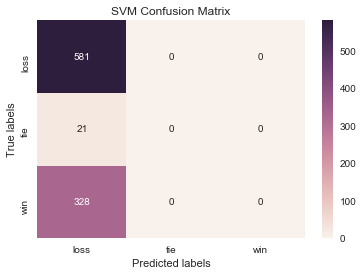

In [236]:
import seaborn as sns
%matplotlib inline
cm = confusion_matrix(y_test_classified, y_pred_classified, labels = [0, 1, 2])

ax = sns.heatmap(cm, annot = True, fmt = "d")
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("SVM Confusion Matrix")
ax.xaxis.set_ticklabels(["loss", "tie", "win"])
ax.yaxis.set_ticklabels(["win", "tie", "loss"])